# Final LGBM Model with Bet Sizing

In [1]:
import pandas as pd
import glob
import numpy as np

In [2]:
training_test_df_monthly = pd.read_csv("../data/train_test/train_test_21_days.csv").drop(columns="Unnamed: 0")
training_test_df_monthly.date = pd.to_datetime(training_test_df_monthly.date)

# Read in Price

In [3]:
price_df_yf = []

for path in glob.glob("../data/market_data_yf/*"):
    
    ticker = path.split("\\")[1].replace(".csv", "")
    
    curr_df = pd.read_csv(path)
    curr_df.Date = pd.to_datetime(curr_df.Date)
    curr_df[ticker] = curr_df["Adj Close"]
    curr_df = curr_df.set_index("Date")[[ticker]]
    
    price_df_yf.append(curr_df)
price_df_yf = pd.concat(price_df_yf, axis=1)

In [4]:
price_df_investingdotcom = []

for path in glob.glob("../data/market_data_investingdotcom/*"):
    
    ticker = path.split("\\")[1].replace(" Historical Data.csv", "")
    
    curr_df = pd.read_csv(path)
    curr_df.Date = pd.to_datetime(curr_df.Date)
    curr_df[ticker] = curr_df["Price"]
    curr_df = curr_df.set_index("Date")[[ticker]]
    
    price_df_investingdotcom.append(curr_df)
price_df_investingdotcom = pd.concat(price_df_investingdotcom, axis=1)

In [5]:
backtest_dates = pd.DataFrame(pd.bdate_range("2009-01-01", "2023-02-10")).rename(columns={0:"Date"})
price_df_yf = backtest_dates.merge(price_df_yf, on ="Date")
price_df_investingdotcom = backtest_dates.merge(price_df_investingdotcom, on ="Date")
price_df = price_df_investingdotcom.merge(price_df_yf, on="Date")
price_df = price_df.set_index("Date")

In [6]:
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Triple Barrier to Obtain Returns

In [7]:
from tqdm.notebook import tqdm
from numpy_ext import rolling_apply

def triple_barrier_return(price_df, vertical_barrier = 21, factor = 0.7):
    
    """
    Triple barrier method to label returns.
    All barriers active
    - Upper barrier for positive returns
    - Verticle barrier to imply returns aren't significant enough (neutral)
    - Lower barrier for negative returns
    
    vertical_barrier: time in days until we classify as 0
    factor: Multiple of volatility to define upper and lower barrier. Higher factor means we consider only significant moves
    
    """
    # Now we change this to get returns
    def get_return(returns, barrier):
        barrier = barrier[0]
        rtn = pd.Series(returns).cumsum()
        if np.isnan(barrier):
            return np.nan
        for r in rtn:
            if r > barrier:
                return r
            elif r < -barrier:
                return r

        return rtn.values[-1]

    log_returns_df = np.log(price_df).diff().loc["2010-01-01":]

    volatility = log_returns_df.copy()
    # Obtain exponential moving average standard deviation
    volatility = volatility.ewm(span = vertical_barrier).std()
    # Scale to period, e.g * 260**0.5 to annualize
    volatility = volatility * (vertical_barrier**0.5)
    # Backfill accordingly in case too much data burned
    # We have 2009-01-01 data onwards
    barrier_thresholds = volatility.backfill(limit=vertical_barrier).loc["2010-01-01":] * factor
    barrier_thresholds[log_returns_df.isnull()] = np.nan

    triple_barrier_target_df = pd.DataFrame(index=barrier_thresholds.index)

    for ticker in tqdm(log_returns_df.columns):
        current_df = log_returns_df[[ticker]].merge(barrier_thresholds[[ticker]], on="Date")
        current_df.columns = ["Returns", "Barrier"]
        triple_barrier_target_df[ticker] = rolling_apply(get_return, vertical_barrier, current_df.Returns.values, current_df.Barrier.values)
        
    triple_barrier_target_df = triple_barrier_target_df.shift(-vertical_barrier)
    
    return triple_barrier_target_df

In [8]:
triple_barrier_returns_df_21_days_07_factor = triple_barrier_return(price_df, vertical_barrier = 21, factor=0.7)

  0%|          | 0/775 [00:00<?, ?it/s]

In [9]:
triple_barrier_target_df_final = triple_barrier_returns_df_21_days_07_factor.reset_index().melt(id_vars="Date").rename(columns={"Date":"date"})

In [10]:
triple_barrier_target_df_final.columns = ["date", "ticker", "return"]

In [11]:
training_test_df_monthly = training_test_df_monthly.merge(triple_barrier_target_df_final, how="left", on = ["date", "ticker"])

# Return and Original Target are in the same direction

In [12]:
training_test_df_monthly[["date", "ticker", "target", "return"]].head()

,date,ticker,target,return
0,2010-01-04,AABA,-1.0,-0.043017
1,2010-01-05,AABA,-1.0,-0.050591
2,2010-01-06,AABA,-1.0,-0.078103
3,2010-01-07,AABA,-1.0,-0.078447
4,2010-01-08,AABA,-1.0,-0.050348


# Prepare Out of Fold Predictions

In [13]:
training_df = training_test_df_monthly[(training_test_df_monthly.date < "2019-12-01")].reset_index(drop=True).copy()
test_df = training_test_df_monthly[(training_test_df_monthly.date >= "2020-01-01")].reset_index(drop=True).copy()

In [14]:
del training_test_df_monthly

#### This is out of fold prediction

In [15]:
final_prediction_dataframe_monthly = pd.read_csv("../results/final_prediction_dataframe_monthly.csv", index_col=0)

In [16]:
# Alphas
x_vals = ['alpha001', 'alpha002', 'alpha003', 'alpha004', 'alpha005', 'alpha006', 'alpha007', 
          'alpha008', 'alpha009', 'alpha010', 'alpha011', 'alpha012', 'alpha013', 'alpha014', 
          'alpha015', 'alpha016', 'alpha017', 'alpha018', 'alpha019','alpha020','alpha021',
          'alpha022','alpha023','alpha024','alpha025','alpha026','alpha027','alpha028',
          'alpha029','alpha030','alpha032','alpha033','alpha034','alpha035','alpha036',
          'alpha037','alpha038','alpha040','alpha041','alpha042','alpha043','alpha044',
          'alpha045','alpha046','alpha047','alpha049','alpha050','alpha051','alpha052',
          'alpha053','alpha055','alpha060','alpha061','alpha062','alpha064','alpha065',
          'alpha068','alpha074','alpha075','alpha078','alpha081','alpha085','alpha086',
          'alpha094','alpha095','alpha099','alpha101','T10Y_minus_2Y','T10Y_minus_2Y_1M_Change',
          'Inflation_Breakeven_Level','Inflation_Breakeven_1M_Change','Real_GDP_Level','GDP_Growth_2Q',
          'PMI_Surprise_Mom','PMI_1Q_Forecast_Change','nyt_news_ChatGPT_sentiment',
          'nyt_news_finbert_positive','nyt_news_finbert_negative','nyt_news_finbert_neutral',
          'nyt_news_lmd_negative_words_count','nyt_news_lmd_positive_words_count',
          'nyt_news_lmd_uncertain_words_count','nyt_news_lmd_litigious_words_count',
          'nyt_news_lmd_strong_modal_words_count','nyt_news_lmd_weak_modal_words_count',
          'nyt_news_word_count','nyt_news_news_count','nyt_news_has_nyt_news','analyst_news_lmd_negative_words_count',
          'analyst_news_lmd_positive_words_count','analyst_news_lmd_uncertain_words_count',
          'analyst_news_lmd_litigious_words_count','analyst_news_lmd_strong_modal_words_count',
          'analyst_news_lmd_weak_modal_words_count','analyst_news_finbert_positive',
          'analyst_news_finbert_negative','analyst_news_finbert_neutral','analyst_news_news_count',
          'analyst_news_has_analyst_news','us_news_lmd_negative_words_count',
          'us_news_lmd_positive_words_count','us_news_lmd_uncertain_words_count',
          'us_news_lmd_litigious_words_count','us_news_lmd_strong_modal_words_count',
          'us_news_lmd_weak_modal_words_count','us_news_finbert_positive','us_news_finbert_negative',
          'us_news_finbert_neutral','us_news_news_count','us_news_has_us_news']

In [17]:
X_train = training_df.copy()
y_train = X_train.target.copy()

X_test = test_df.copy()
y_test = X_test.target.copy()

In [18]:
import pickle
with open('../model/LGBM.sav', 'rb') as f:
    direction_model_lgbm = pickle.load(f)

In [19]:
preds_test = direction_model_lgbm.predict(X_test[x_vals])

In [20]:
import pickle
with open('../model/RandomForest.sav', 'rb') as f:
    direction_model_RF = pickle.load(f)

In [21]:
preds_test_RF = direction_model_RF.predict(X_test[x_vals])

In [22]:
X_train_with_preds = X_train.merge(final_prediction_dataframe_monthly, left_index=True, right_index=True, how="left")
X_train_with_preds[["LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]] = X_train_with_preds[["LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]].fillna(0)
X_test_with_preds = X_test.copy()
X_test_with_preds["LGBMClassifier"] = preds_test
X_test_with_preds["RandomForestClassifier"] = preds_test_RF

#### Add out of fold prediction from cross validation (unti 2019) with out of sample prediction (2020 onwards)

In [23]:
full_period_out_of_fold_preds = pd.concat([X_train_with_preds, X_test_with_preds])

In [24]:
del X_train_with_preds
del X_test_with_preds

# Now to Illustrate Returns without Bet Sizing

In [25]:
returns_df = price_df.pct_change().copy()
remove_rtns = (returns_df > 0.4).sum()[(returns_df > 0.4).sum() > 10].index
returns_df = returns_df[[c for c in returns_df.columns if c not in remove_rtns]]
returns_df = returns_df.clip(upper=0.3, lower=-0.3)

In [26]:
full_dates = pd.DataFrame(pd.bdate_range("2010-01-04", "2023-02-10")).rename(columns={0:"date"})

In [27]:
mask = pd.read_csv("../data/historical_sp500_mask_2010_onwards.csv").rename(columns={"Unnamed: 0":"date"})
mask.date = pd.to_datetime(mask.date)
mask.set_index("date", inplace=True)
mask = full_dates.merge(mask, on="date", how="left").set_index("date")
mask = mask[returns_df.columns[returns_df.columns.isin(mask.columns)]]

In [28]:
model_returns_full = dict()
for model_name in ["LGBMClassifier"]:
    position_long_only_signal = full_dates.merge(full_period_out_of_fold_preds.pivot(index="date", columns="ticker", values=model_name).reset_index(), on="date", how="left")
    position_long_only_signal = position_long_only_signal.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
    position_long_only_signal = position_long_only_signal[mask.columns[mask.columns.isin(position_long_only_signal.columns)]]
    position_long_only_signal = position_long_only_signal * mask
    position_long_only_weight = position_long_only_signal.div(position_long_only_signal.sum(axis=1), axis=0).fillna(0)
    common_columns = position_long_only_weight.columns[position_long_only_weight.columns.isin(returns_df.columns)]
    position_long_only_weight = position_long_only_weight[common_columns]
    port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
    port_returns = full_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[position_long_only_weight.columns]
    portfolio_long_only = (port_returns[position_long_only_weight.columns] * position_long_only_weight.fillna(0))
    
    model_returns_full[model_name] = portfolio_long_only.sum(axis=1)

In [29]:
import yfinance as yf

price_dataframe = yf.download("^GSPC")
price_dataframe = full_dates.merge(price_dataframe.reset_index().rename(columns={"Date":"date"})).set_index("date")

[*********************100%***********************]  1 of 1 completed


In [30]:
sp_500_sr = round(((price_dataframe[["Adj Close"]].pct_change()).mean() / (price_dataframe[["Adj Close"]].pct_change()).std() * 260 **0.5), 2)
sp_500_sr = sp_500_sr.values[0]

In [31]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Cumulative Log Returns (%)')

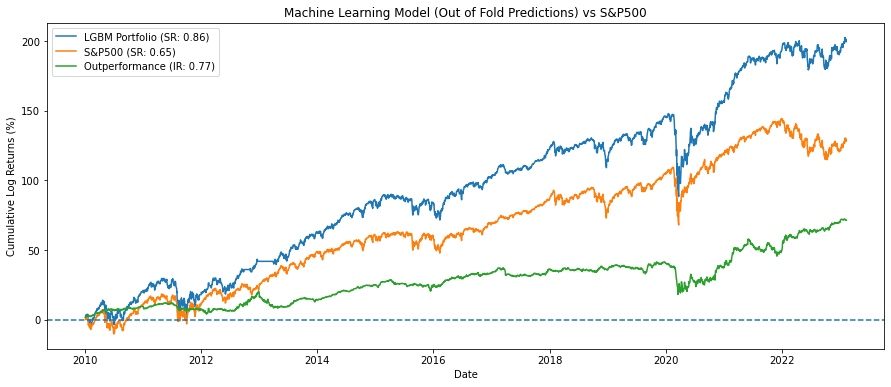

In [32]:
plt.figure(figsize=(15, 6))
    
ew_portfolio = pd.DataFrame(model_returns_full).mean(axis=1)
ew_sr = round((ew_portfolio.mean() / ew_portfolio.std() * 260**0.5), 2)
ew_portfolio = np.log(ew_portfolio+1).cumsum()*100

plt.plot(ew_portfolio, label=F"LGBM Portfolio (SR: {ew_sr})")

sp_500 = np.log(price_dataframe[["Adj Close"]].pct_change()+1).cumsum()*100
plt.plot(sp_500, label=F"S&P500 (SR: {sp_500_sr})")

out_perf = pd.concat([pd.DataFrame(model_returns_full).mean(axis=1), price_dataframe[["Adj Close"]].pct_change()],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500) * 100
information_ratio = round((out_perf.out_perf.mean() / out_perf.out_perf.std() * 260**0.5), 2)

out_perf = pd.concat([ew_portfolio, sp_500],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500.ffill())
plt.plot(out_perf.out_perf, label=f"Outperformance (IR: {information_ratio})")

plt.axhline(0, ls="--")
plt.legend()
plt.title("Machine Learning Model (Out of Fold Predictions) vs S&P500")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Returns (%)")

# Now we use Bet Sizing

# This Is The PNL of Each Trade

In [33]:
full_period_out_of_fold_preds["LGBMClassifier_PNL"] = full_period_out_of_fold_preds.LGBMClassifier * full_period_out_of_fold_preds["return"]
full_period_out_of_fold_preds["RandomForestClassifier_PNL"] = full_period_out_of_fold_preds.RandomForestClassifier * full_period_out_of_fold_preds["return"]

In [34]:
full_period_out_of_fold_preds.LGBMClassifier_PNL = np.sign(full_period_out_of_fold_preds.LGBMClassifier_PNL)
full_period_out_of_fold_preds.RandomForestClassifier_PNL = np.sign(full_period_out_of_fold_preds.RandomForestClassifier_PNL)

In [35]:
full_period_out_of_fold_preds.LGBMClassifier_PNL = full_period_out_of_fold_preds.LGBMClassifier_PNL.clip(lower=0)
full_period_out_of_fold_preds.RandomForestClassifier_PNL = full_period_out_of_fold_preds.RandomForestClassifier_PNL.clip(lower=0)

In [36]:
full_period_out_of_fold_preds.reset_index(drop=True, inplace=True)

In [37]:
training_df = full_period_out_of_fold_preds[(full_period_out_of_fold_preds.date < "2019-12-01")].reset_index(drop=True).copy()
test_df = full_period_out_of_fold_preds[(full_period_out_of_fold_preds.date >= "2020-01-01")].reset_index(drop=True).copy()

# We also want out of fold predictions for bet sizing

In [38]:
fold_1 = training_df[(training_df.date < "2011-12-01")].index.values
fold_2 = training_df[(training_df.date >= "2012-01-01") & (training_df.date < "2013-12-01")].index.values
fold_3 = training_df[(training_df.date >= "2014-01-01") & (training_df.date < "2015-12-01")].index.values
fold_4 = training_df[(training_df.date >= "2016-01-01") & (training_df.date < "2017-12-01")].index.values
fold_5 = training_df[(training_df.date >= "2018-01-01") & (training_df.date < "2019-12-01")].index.values

In [39]:
cv_folds = [(np.concatenate([fold_2, fold_3, fold_4, fold_5]), fold_1),
(np.concatenate([fold_1, fold_3, fold_4, fold_5]), fold_2),
(np.concatenate([fold_1, fold_2, fold_4, fold_5]), fold_3),
(np.concatenate([fold_1, fold_2, fold_3, fold_5]), fold_4),
(np.concatenate([fold_1, fold_2, fold_3, fold_4]), fold_5)]

In [40]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
from sklearn.metrics import f1_score, accuracy_score

In [42]:
X_train = training_df.copy()
y_train = X_train["LGBMClassifier_PNL"].copy().fillna(0)
X_train[x_vals] = X_train[x_vals].astype(float)

X_test = test_df.copy()
y_test = X_test["LGBMClassifier_PNL"].copy().fillna(0)
X_test[x_vals] = X_test[x_vals].astype(float)

# Final model is LGBM

In [43]:
monthly_all_predictions = {}
monthly_all_proba = {}
monthly_all_accuracy = {}
monthly_all_f1_scores = {}
for est_name in ['LGBMClassifier']:
    if est_name == "LGBMClassifier":
        current_estimator = LGBMClassifier()
    elif est_name == "RandomForestClassifier":
        current_estimator = RandomForestClassifier()
    else:
        print("Error")
        break
    monthly_all_predictions[est_name] = []
    monthly_all_accuracy[est_name] = []
    monthly_all_f1_scores[est_name] = []
    monthly_all_proba[est_name] = []
    
    for i in tqdm(range(5)):
        in_fold_index, out_fold_index = cv_folds[i]
        X_in_fold, y_in_fold = X_train.iloc[in_fold_index][x_vals], y_train.iloc[in_fold_index]
        X_out_of_fold, y_out_of_fold = X_train.iloc[out_fold_index][x_vals], y_train.iloc[out_fold_index]
        current_estimator.fit(X_in_fold, y_in_fold)
        
        y_pred = current_estimator.predict(X_out_of_fold)
        accuracy = accuracy_score(y_true=y_out_of_fold, y_pred=y_pred)
        f1 = f1_score(y_true=y_out_of_fold, y_pred=y_pred, average="macro")
        y_pred_proba = current_estimator.predict_proba(X_out_of_fold)
        
        monthly_all_proba[est_name].append(y_pred_proba)
        monthly_all_predictions[est_name].append(y_pred)
        monthly_all_accuracy[est_name].append(accuracy)
        monthly_all_f1_scores[est_name].append(f1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
lgbm_bet_sizing = pd.DataFrame(np.concatenate(monthly_all_proba["LGBMClassifier"]), index=np.concatenate([fold_1,fold_2,fold_3,fold_4,fold_5]))
lgbm_bet_sizing.columns = ["Loss", "Profit"]

In [45]:
direction_model = LGBMClassifier()
direction_model.fit(X_train[x_vals], y_train)

LGBMClassifier()

In [46]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[120142  35350]
 [ 91001  42837]]


Text(0.5, 1.0, 'Confusion Matrix (LGBM Bet Sizing)')

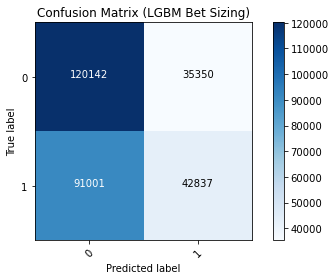

In [47]:
import seaborn as sns

test_preds = direction_model.predict(X_test[x_vals])

cm = confusion_matrix(y_test, test_preds)
plot_confusion_matrix(cm, [0, 1])
plt.title("Confusion Matrix (LGBM Bet Sizing)")

In [48]:
from sklearn.metrics import classification_report
print("Classification Report for Test")
print(classification_report(y_test, test_preds))

Classification Report for Test
              precision    recall  f1-score   support

         0.0       0.57      0.77      0.66    155492
         1.0       0.55      0.32      0.40    133838

    accuracy                           0.56    289330
   macro avg       0.56      0.55      0.53    289330
weighted avg       0.56      0.56      0.54    289330



In [49]:
preds_test = direction_model.predict_proba(X_test[x_vals])

In [50]:
X_test_with_preds = X_test.copy()
X_test_with_preds[["Loss", "Profit"]] = preds_test

In [51]:
training_df_preds = training_df.merge(lgbm_bet_sizing, left_index=True, right_index=True, how="left")

In [52]:
full_period_out_of_fold_preds_WITH_BET_SIZING = pd.concat([training_df_preds, X_test_with_preds])

In [53]:
full_period_out_of_fold_preds_WITH_BET_SIZING["LGBMClassifier_BetSized"] = full_period_out_of_fold_preds_WITH_BET_SIZING.LGBMClassifier * full_period_out_of_fold_preds_WITH_BET_SIZING.Profit

In [54]:
model_returns_full_no_betsize = dict()
for model_name in ["LGBMClassifier"]:
    position_long_only_signal = full_dates.merge(full_period_out_of_fold_preds.pivot(index="date", columns="ticker", values=model_name).reset_index(), on="date", how="left")
    position_long_only_signal = position_long_only_signal.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
    position_long_only_signal = position_long_only_signal[mask.columns[mask.columns.isin(position_long_only_signal.columns)]]
    position_long_only_signal = position_long_only_signal * mask
    position_long_only_weight = position_long_only_signal.div(position_long_only_signal.sum(axis=1), axis=0).fillna(0)
    common_columns = position_long_only_weight.columns[position_long_only_weight.columns.isin(returns_df.columns)]
    position_long_only_weight = position_long_only_weight[common_columns]
    port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
    port_returns = full_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[position_long_only_weight.columns]
    portfolio_long_only = (port_returns[position_long_only_weight.columns] * position_long_only_weight.fillna(0))
    
    model_returns_full_no_betsize[model_name] = portfolio_long_only.sum(axis=1)

# Long only if >50% Confidence, Bet Size the Rest According to Prob

In [55]:
model_returns_full = dict()
for model_name in ["LGBMClassifier_BetSized"]:
    position_long_only_signal = full_dates.merge(full_period_out_of_fold_preds_WITH_BET_SIZING.pivot(index="date", columns="ticker", values=model_name).reset_index(), on="date", how="left")
    position_long_only_signal = position_long_only_signal.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
    position_long_only_signal = position_long_only_signal[mask.columns[mask.columns.isin(position_long_only_signal.columns)]]
    position_long_only_signal = (position_long_only_signal>0.5) * mask
    
    total_positions = (position_long_only_signal).sum(axis=1)
    
    position_long_only_weight = position_long_only_signal.div(total_positions, axis=0).fillna(0)
    common_columns = position_long_only_weight.columns[position_long_only_weight.columns.isin(returns_df.columns)]
    position_long_only_weight = position_long_only_weight[common_columns]
    port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
    port_returns = full_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[position_long_only_weight.columns]
    portfolio_long_only = (port_returns[position_long_only_weight.columns] * position_long_only_weight.fillna(0))
    
    model_returns_full[model_name] = portfolio_long_only.sum(axis=1)

Text(0, 0.5, 'Cumulative Log Returns (%)')

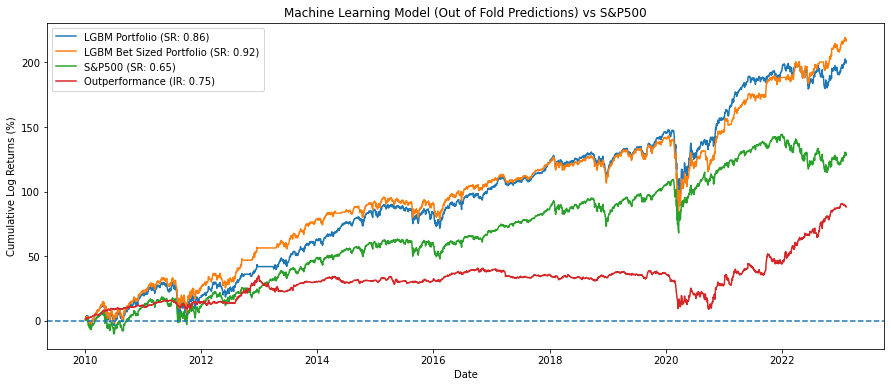

In [56]:
plt.figure(figsize=(15, 6))
    
ew_portfolio = pd.DataFrame(model_returns_full_no_betsize).mean(axis=1)
ew_sr = round((ew_portfolio.mean() / ew_portfolio.std() * 260**0.5), 2)
ew_portfolio = np.log(ew_portfolio+1).cumsum()*100

plt.plot(ew_portfolio, label=F"LGBM Portfolio (SR: {ew_sr})")

ew_portfolio = pd.DataFrame(model_returns_full).mean(axis=1)
ew_sr = round((ew_portfolio.mean() / ew_portfolio.std() * 260**0.5), 2)
ew_portfolio = np.log(ew_portfolio+1).cumsum()*100

plt.plot(ew_portfolio, label=F"LGBM Bet Sized Portfolio (SR: {ew_sr})")

sp_500 = np.log(price_dataframe[["Adj Close"]].pct_change()+1).cumsum()*100
plt.plot(sp_500, label=F"S&P500 (SR: {sp_500_sr})")

out_perf = pd.concat([pd.DataFrame(model_returns_full).mean(axis=1), price_dataframe[["Adj Close"]].pct_change()],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500) * 100
information_ratio = round((out_perf.out_perf.mean() / out_perf.out_perf.std() * 260**0.5), 2)

out_perf = pd.concat([ew_portfolio, sp_500],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500.ffill())
plt.plot(out_perf.out_perf, label=f"Outperformance (IR: {information_ratio})")

plt.axhline(0, ls="--")
plt.legend()
plt.title("Machine Learning Model (Out of Fold Predictions) vs S&P500")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Returns (%)")

Text(0, 0.5, 'Cumulative Returns (%)')

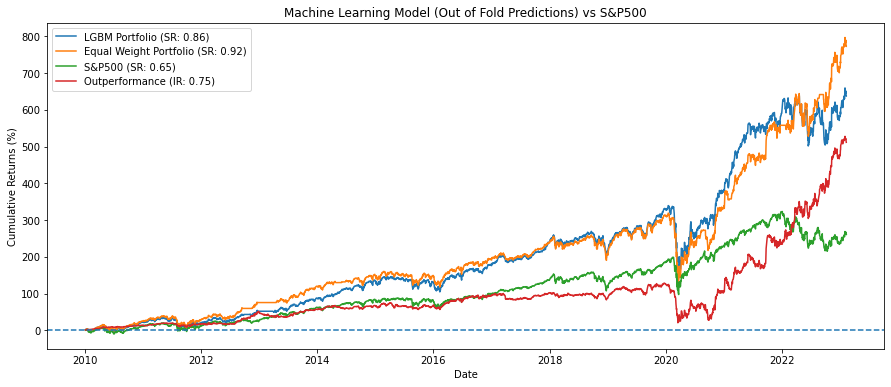

In [75]:
plt.figure(figsize=(15, 6))
    
ew_portfolio_no_bet = pd.DataFrame(model_returns_full_no_betsize).mean(axis=1)
ew_sr = round((ew_portfolio_no_bet.mean() / ew_portfolio_no_bet.std() * 260**0.5), 2)
ew_portfolio_no_bet_cum_rtn = (ew_portfolio_no_bet+1).cumprod()*100 - 100

plt.plot(ew_portfolio_no_bet_cum_rtn, label=F"LGBM Portfolio (SR: {ew_sr})")

ew_portfolio = pd.DataFrame(model_returns_full).mean(axis=1)
ew_sr = round((ew_portfolio.mean() / ew_portfolio.std() * 260**0.5), 2)
ew_portfolio = (ew_portfolio+1).cumprod()*100 - 100

plt.plot(ew_portfolio, label=F"Equal Weight Portfolio (SR: {ew_sr})")

sp_500 = (price_dataframe[["Adj Close"]].pct_change()+1).cumprod()*100 - 100
plt.plot(sp_500, label=F"S&P500 (SR: {sp_500_sr})")

out_perf = pd.concat([pd.DataFrame(model_returns_full).mean(axis=1), price_dataframe[["Adj Close"]].pct_change()],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500) * 100
information_ratio = round((out_perf.out_perf.mean() / out_perf.out_perf.std() * 260**0.5), 2)

out_perf = pd.concat([ew_portfolio, sp_500],axis=1)
out_perf.columns = ["model", "sp500"]
out_perf["out_perf"] = (out_perf.model - out_perf.sp500.ffill())
plt.plot(out_perf.out_perf, label=f"Outperformance (IR: {information_ratio})")

plt.axhline(0, ls="--")
plt.legend()
plt.title("Machine Learning Model (Out of Fold Predictions) vs S&P500")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")

In [73]:
ew_portfolio

date
2010-01-04      1.396051
2010-01-05      1.679917
2010-01-06      2.112362
2010-01-07      2.339342
2010-01-08      2.656819
                 ...    
2023-02-06    782.670212
2023-02-07    789.341892
2023-02-08    781.371679
2023-02-09    772.488471
2023-02-10    772.488471
Length: 3420, dtype: float64

In [74]:
ew_portfolio_no_bet_cum_rtn

date
2010-01-04      1.608133
2010-01-05      2.082304
2010-01-06      2.422746
2010-01-07      3.122775
2010-01-08      3.389956
                 ...    
2023-02-06    644.121226
2023-02-07    651.220327
2023-02-08    643.925421
2023-02-09    637.268559
2023-02-10    637.268559
Length: 3420, dtype: float64